<h1><center>Classification of breast cancer images</center></h1>

#### Word Count:1989
#### KV7006_w23006002

### Introduction
Breast cancer is most common seen type of cancer in women in world with estimated 570,000 deaths in 2015. In a year, over 1.5 million women, which is 25% of women with all types of cancer, are diagnosed with breast cancer on a global scale (Sun et al., 2017). Breast cancer stands as the primary contributor to cancer-related mortality in developing nations, and as the secondary cause of cancer-associated deaths among women in developed regions, with lung cancer being the leading cause. Machine learning has recently been contributing to diagnosing breast cancer on a noticeable level which makes machine learning a vital part in of medical research. Recent advancement and changes in this field has led to more accurate and intelligent decision making and diagnosis with self-reliant computer aided diagnosis (Safdar et al., 2019).


In [165]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,optimizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


import keras_tuner as kt
from keras import models
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,precision_score, recall_score,average_precision_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



### Exploratory data analysis
Exploratory data analysis was performed on the data to understand the data, its structure, variables in the data and their meanings. By performing EDA, pixel values, their intensities for the image, and other important features were understood. Visualizations and summaries were generated to gain insights of the data and its important features.
For the data breast cancer mage classification, very first step of the EDA was to plot some images to gain insights about how image data looks when its cancer cell and vice versa.
Image shape and its associated labels were printed to understand the structure of the dataset.
There are 5547 images in the data set of each image with pixel of 50*50 in the three coloured images. So, it is resented as (5547,50,50,3).
Labels associated with the images are also same in number stored in Y data, where 0 is non-IDC cell and 1 is IDC cell.
Basic statistics for e.g. Mean, median, stand deviation of the pixels in the images.
Every image in the dataset is displayed in R, G, B format hence the pixel intensity histogram was plotted to see which colour is dominating in the image.
Image[6] which is non IDC image and its respective pixel intensity graph is plotted to see which colour intensifies more in the image which is observed as red colour has more intensity than others colours in the images which can be validated with the respective image itself.
Data distribution was carried out to check if there if significant imbalances in the data.
In the given data of breast cancer images there are 49.74% label instances which is 2759 instances of the label 0 and rest which is 50.26% containing 2788 instances of the data are the label 1.


In [297]:
X= np.load('C:/Users/shakuntal shinde/Downloads/X.npy')
Y = np.load('C:/Users/shakuntal shinde/Downloads/Y.npy')

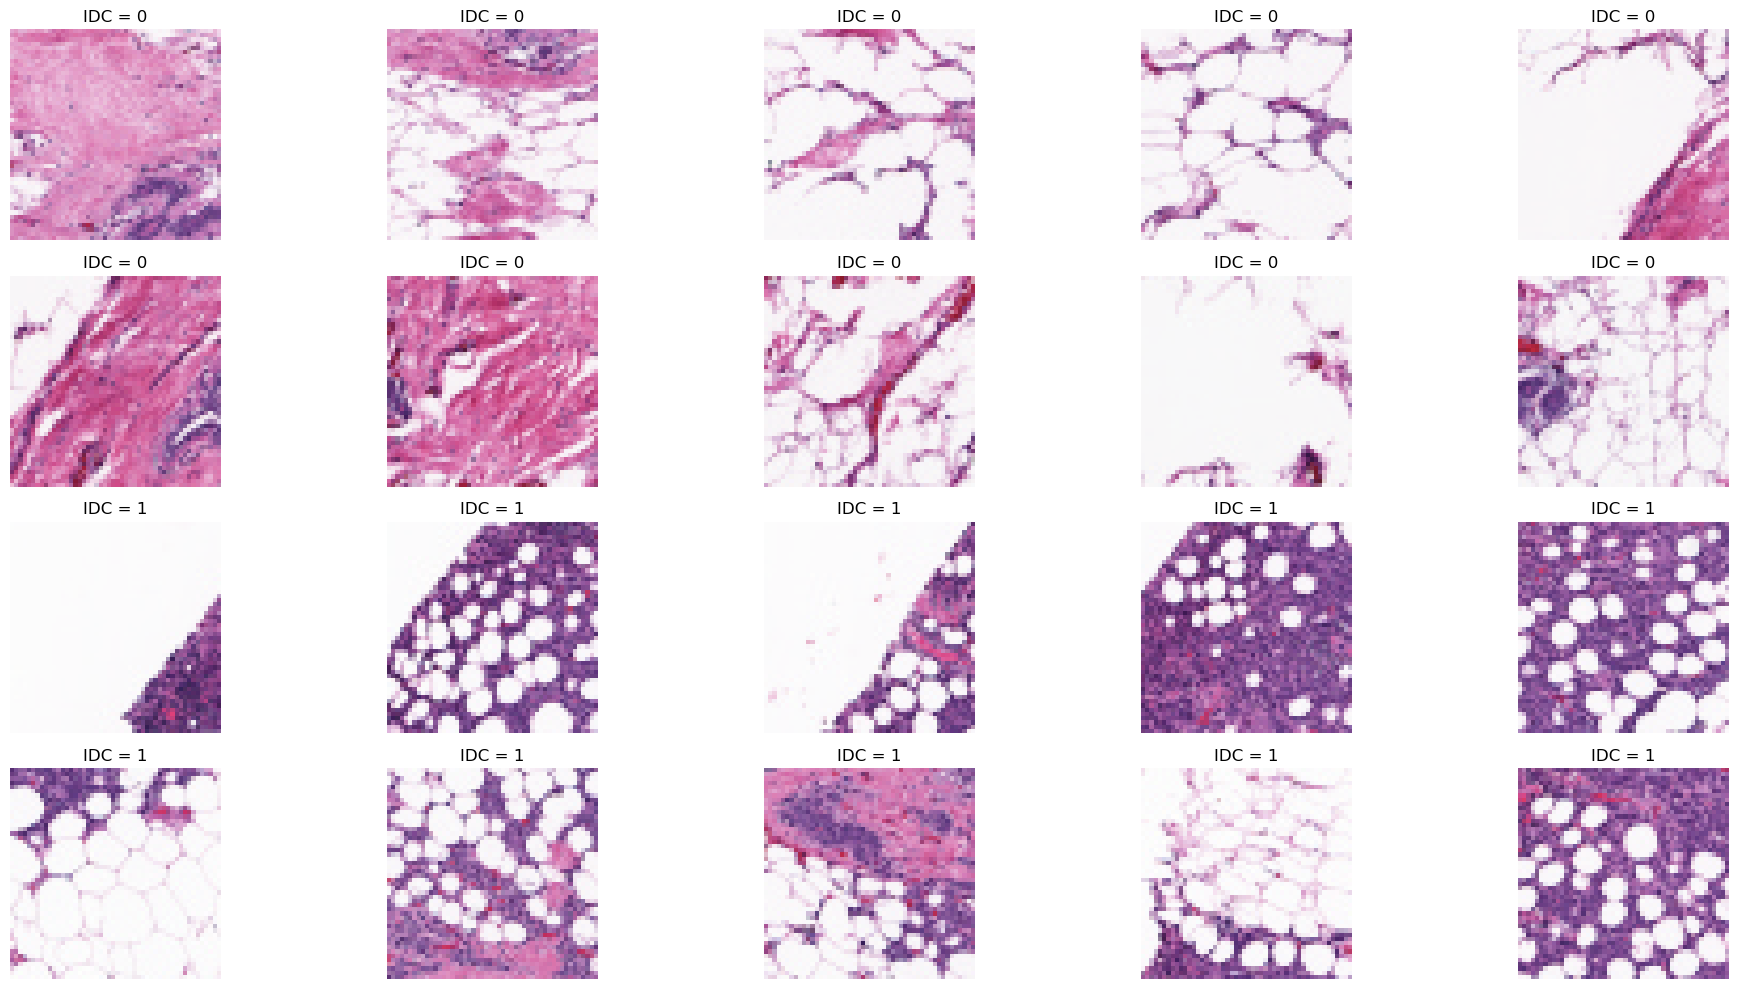

In [80]:

imgs_0 = X[Y == 0]  
imgs_1 = X[Y == 1]  


plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(4, 5, i + 1)
    plt.title('IDC = 0')
    plt.imshow(imgs_0[i])
    plt.axis('off')

for i in range(10):
    plt.subplot(4, 5, i + 11)
    plt.title('IDC = 1')
    plt.imshow(imgs_1[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [81]:
flattened_images = [img.flatten() for img in X]

flattened_images = np.array(flattened_images)

mean_pixel_value = np.mean(flattened_images)
std_pixel_value = np.std(flattened_images)
min_pixel_value = np.min(flattened_images)
max_pixel_value = np.max(flattened_images)

print(f"Mean pixel value: {mean_pixel_value}")
print(f"Standard deviation of pixel values: {std_pixel_value}")
print(f"Min pixel value: {min_pixel_value}")
print(f"Max pixel value: {max_pixel_value}")


Mean pixel value: 185.03374477495342
Standard deviation of pixel values: 47.24814394300702
Min pixel value: 2
Max pixel value: 255


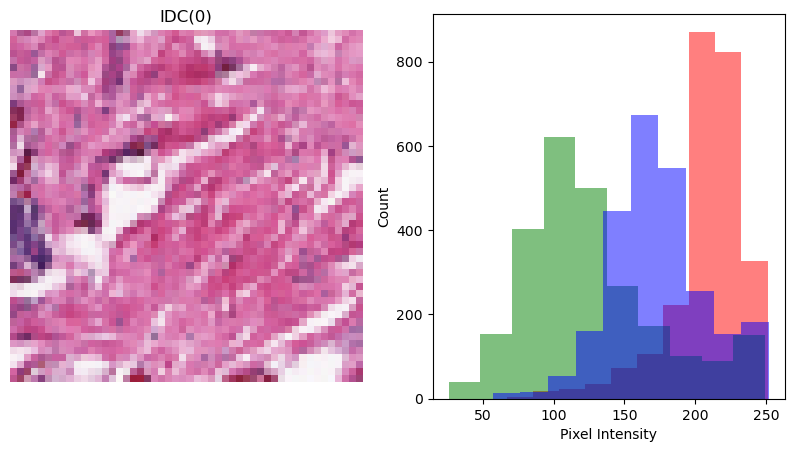

In [82]:
def Pixel_intensity(p):
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(p)
    plt.axis('off')
    plt.title('IDC(1)' if Y[1] else 'IDC(0)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(p[:,:,0].flatten(),color='r', alpha=0.5);
    plt.hist(p[:,:,1].flatten(),color='g', alpha=0.5);
    plt.hist(p[:,:,2].flatten(),color='b', alpha=0.5);
Pixel_intensity(X[6])

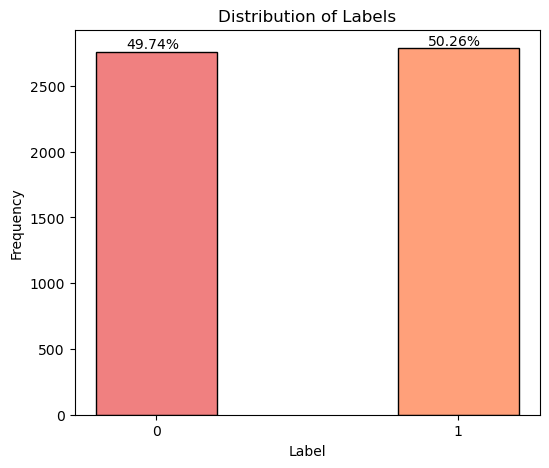

Label 0: 2759 instances
Label 0: 49.74% of the dataset
Label 1: 2788 instances
Label 1: 50.26% of the dataset


In [330]:
unique_labels, counts = np.unique(Y, return_counts=True)
total_instances = len(Y)
percentages = (counts / total_instances) * 100

plt.figure(figsize=(6, 5))
bars = plt.bar(unique_labels, counts, color=['lightcoral', 'lightsalmon'], edgecolor='black', width=0.4)

plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.xticks(unique_labels)

for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0 - 0.1, yval, f'{percentage:.2f}%', va='bottom')

plt.show()
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} instances")
    proportion = count / total_instances
    print(f"Label {label}: {proportion:.2%} of the dataset")



### Preprocessing
Once the exploratory data analysis was done on the data set, data was split into testing and training sets. For the deep learning model training the data was first split into three different sets as train, test, and validation. The training set split was largest portion of the dataset which is used to train the model. Validation data is used in hyperparameter tuning to make sure the model doesn’t just learn but is able to generalise in new data when provided, also it helps avoid overfitting of the model and the testing data was used to predict and evaluate the model performance. 
The data split then normalised to make sure data is on the scale of 0 and 1 or -1 and 1. Normalization helps data to be on same scale as a result it helps the algorithm converge faster when normalization makes sure every feature is contributing same in the training and learning process. In short normalization mitigates the issues that produces from uneven scale of the features, and it helps improve numerical stability of the model.
Image flattening is one of the common preprocessing steps. Image flattening is done to convert multidimensional data into single dimensional. Flattening is done to provide data to certain machine learning algorithm as some of them require 1D array as input. In case of deep learning model, after extracting and completing the spatial features the output needs to be flatten out before feeding it to classification tasks, but this flattening is done in the CNN layers itself.
Data augmentation is common image preprocessing task mostly done after splitting the data and before feeding it into the models. A name suggest, data augmentation is nothing but   modifying the original images to provide rich picture as input to the models.
For the data augmentation, random zoom, random rotation, enhanced the brightness and contrast to provide better image as input.



In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [302]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val=X_val/255.0

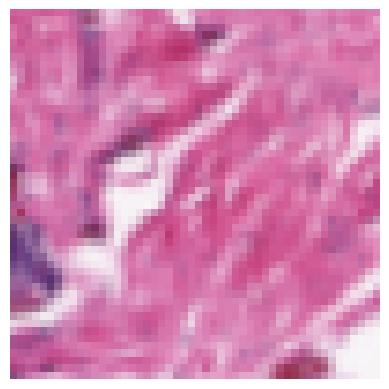

In [243]:

data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.05),
  layers.RandomZoom(0.05),
  layers.Lambda(lambda x: tf.image.adjust_brightness(x, 0.1)),  
])

plt.axis('off')
plt.imshow(data_augmentation(X)[6].numpy().astype("uint8"))

### Building, training, and validation of suitable models:
In the realm of deep learning, significant progress has been achieved in supporting researchers in performing tasks such as segmentation, feature extraction, classification, and detection on raw medical images acquired through various imaging modalities including digital breast tomosynthesis, digital mammography, magnetic resonance imaging, and ultrasound imaging (Taye Girma Debelee et al., 2019). Convolution neural network (CNN) is used as deep learning algorithm to classify the breast cancer images. In CCN architecture, 4 convolution layers were build applying filter as 16,32,64,128 respectively and 4 max pooling layers with pooling size (2,2). RELU activation function was used throughout the convolution layers. Drop out layers make sure dropout regularization during the training phase. Given 0.5 drop out value indicates the dropping of the 50% of the input values during training. Further flatten layer makes sure to convert the multidimensional output to be flattened. In the output dense layer, SoftMax activation is used with value 2 denoting probability distribution of the output classes. learning rate specifies how fast or slow the model is being trained and it determines the speed of the model training and batch size acts where batch size denotes number of the input samples training each batch. Optimizers are set to manage loss function where loss function gives difference between.
For the machine learning algorithms, decision tree is built and trained for image classification. Decision tree is supervised learning algorithm which builds tree for image classification where each node represents features and each brand in the tree denotes decision on those features and the leaf denote output of the classification. The nature of this algorithm involves the evaluation of features on an iterative basis. Decision tree algorithms has ability to handle complex data, interpretability and efficiency while working on image data (Liu, Mihaela Cocea and Ding, 2017).
Support vector machine (SVM) is one of the other machine learning algorithms used for classification due to its robustness to overfitting as it has c parameter for regularization and its margin maximization ability. SVC is its classifier for the classification used for binary and multi class classification for detecting and classifying cancer and non cancer images with regularization and gamma parameters for defining the influence of single training sets. the support vector machine (SVM) has emerged as a proficient paradigm for the task of classification, showcasing a robust mathematical framework for both classification and regression (Mayank Arya Chandra and Bedi, 2018).
Random forest classifier also used for image classification as a part of machine learning model. Random forest does not need much pre-processing like feature scaling and is robust to overfitting. Random forests represent a methodology designed for constructing a classification ensemble utilizing a collection of decision trees that are developed within randomly chosen subspaces of the data (Xu, Ye and Nie, 2012).
Confusion matrix and others performance matrix are displayed for each model to evaluate the model before and after hyperparameter tunning and the results were visualized for better understanding.

### Hyperparameter tuning of the above models:
Hyperparameter is achieved by fine tuning the parameters and giving all related parameters so that it can iterate through all the combination and perform a grid search and return best set of the parameters.
For the CNN hyperparameter, number of layers denotes the ability of each layer to extract data from hierarchical input layers.  Different features are detected by the filters assigned to each layer. Kernel size is kept (3,3) to detect more fine features. As the CNN moves across the input data, strides assigned will capture. Pooling layers in CNN hyperparameter are designed to with pool sizes and strides to avoid overfitting of the model as its down samples the features obtained from convolutional layers. Learning rate, activation function and optimizers are specified as to give best parameter present amongst them.
Tuning above mentioned parameters as mentioned above will ensure effective and significant impact on the model performance which is carried out by techniques like randomly searching or grid search or Bayesian optimization in some cases.
For the hyperparameter tunning of decision tree, GridsearchCV is used to find best combination of the parameter for better performance of the model. Various list of parameters is given in the hyperparameter which consists of criteria, which is used to measure the quality of split. In the criteria parameter, it is set to decide what criteria is used to split the data at each node where strategy of how to split the data at each node is decided on the splitter parameter. Maximum depth of the decision tree is decided on what max_depth parameter gives as best parameter. Internal nodes have splits of data on them and minimum splits to be present are decide on min_samples_leaf. When deciding the number of features while considering splits depending upon max_features and the best parameters returned by this parameter. 
For the hyperparameter tuning of SVM, set of different parameters like c values, gamma values and kernel are given in set of values to find best set of values by using grid search technique. C value has capacity to control the trade-off between the values of low training rate error and respective low testing error. Gamma value decided how far or close the influence of single training is on the learning set. 
Random forest hyperparameter tunning has some of the parameter same as decision tree as its based-on number of decision trees collectively trained and combined. Parameters like n_estimators give the model number of trees to be included in forest and these trees specifically here are decision tree algorithm alone. 



In [332]:
cnn_model = models.Sequential([
    
    data_augmentation,
    
    layers.Conv2D(filters=16, kernel_size=(3, 3),  padding='same',activation='relu', input_shape=(50, 50, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=32, kernel_size=(3, 3),  padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3),  padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3),  padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),

    
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2,activation="softmax")
])

cnn_model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)             │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 25, 25, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 12, 12, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 6, 6, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 3, 3, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,282 (958.13 KB)

 Trainable params: 245,282 (958.13 KB)

 Non-trainable params: 0 (0.00 B)

In [304]:
optimizer = optimizers.Adam(learning_rate=0.001)

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [305]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),callbacks=[early_stopping])


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.5459 - loss: 0.6871 - val_accuracy: 0.7004 - val_loss: 0.5767
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6693 - loss: 0.6108 - val_accuracy: 0.7356 - val_loss: 0.5414
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.7297 - loss: 0.5633 - val_accuracy: 0.6790 - val_loss: 0.6105
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7385 - loss: 0.5360 - val_accuracy: 0.7348 - val_loss: 0.5283
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7515 - loss: 0.5178 - val_accuracy: 0.7494 - val_loss: 0.5111
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.7554 - loss: 0.5223 - val_accuracy: 0.7442 - val_loss: 0.5245
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7453 - loss: 0.5485 - val_accuracy: 0.7648 - val_loss: 0.5040
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7671 - loss: 0.5024 - val_accuracy: 0.7631 

In [306]:
cnn_model.evaluate(X_test,y_test)

y_pred_prob = cnn_model.predict(X_test)

cnn_y_pred = np.argmax(y_pred_prob, axis=1)
print("\nPrecision:", precision_score(y_test, cnn_y_pred, average='macro'))
print("Recall:", recall_score(y_test, cnn_y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, cnn_y_pred, average='macro'))
print("\ncnn_model_cm:\n",confusion_matrix(y_test, cnn_y_pred))


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7684 - loss: 0.5036
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

Precision: 0.778770832010437
Recall: 0.7791172492717436
F1 Score: 0.7788314654761663

cnn_model_cm:
 [[670 194]
 [174 627]]


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


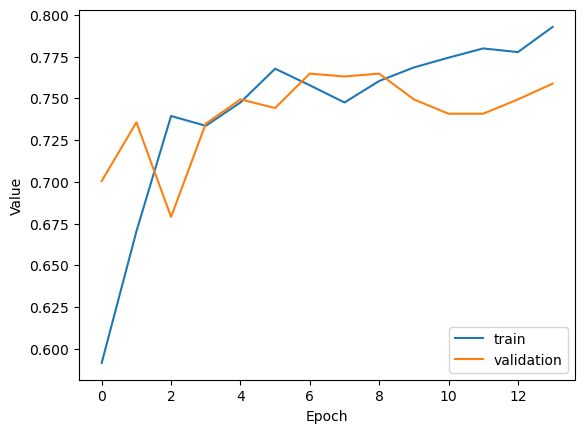

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


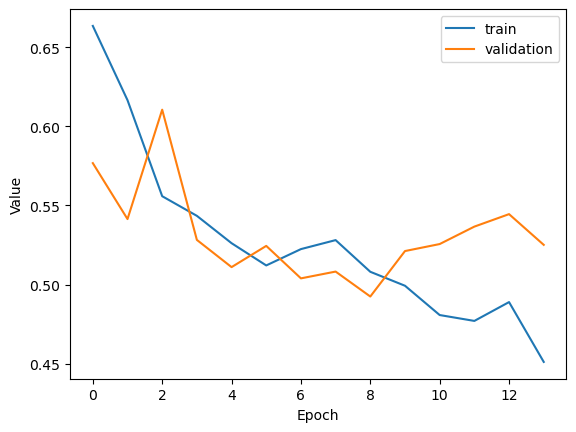

In [307]:
# # training history
print(history.history.keys())
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.show() 

# # training history
print(history.history.keys())
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show() 

In [317]:
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=3)):
        model.add(layers.Conv2D(filters=hp.Choice(f'conv_{i}_filters', values=[32, 64, 128]),
                                 kernel_size=(3, 3),
                                 padding='same',
                                 activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units=hp.Choice('dense_units', values=[64, 128, 256]), activation='relu'))
    
    model.add(layers.Dense(2, activation='softmax'))

    # Compiling
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiating
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='cnn_tuning')

# Searching best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps}")


# Displaying best hyperparameters
print("Best Hyperparameters:")
print(f"Number of convolutional layers: {best_hps.get('num_conv_layers')}")
for i in range(best_hps.get('num_conv_layers')):
    print(f"Convolutional layer {i + 1} - Number of filters: {best_hps.get(f'conv_{i}_filters')}")
print(f"Dense layer - Number of units: {best_hps.get('dense_units')}")


# model build
CNN_best = tuner.hypermodel.build(best_hps)



Reloading Tuner from my_dir\cnn_tuning\tuner0.json
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001998C907410>
Best Hyperparameters:
Number of convolutional layers: 2
Convolutional layer 1 - Number of filters: 128
Convolutional layer 2 - Number of filters: 64
Dense layer - Number of units: 64


c:\Users\shakuntal shinde\anaconda3\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [318]:
# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = CNN_best.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),callbacks=[early_stopping])


CNN_best.evaluate(X_test,y_test)

cnn_y_pred_best = np.argmax(y_pred_prob, axis=1)

print("\nPrecision:", precision_score(y_test, cnn_y_pred_best, average='macro'))
print("Recall:", recall_score(y_test, cnn_y_pred_best, average='macro'))
print("F1 Score:", f1_score(y_test, cnn_y_pred_best, average='macro'))
print("\nCNN_best_cm:\n",confusion_matrix(y_test, cnn_y_pred_best))


Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.5069 - loss: 0.7016 - val_accuracy: 0.6549 - val_loss: 0.6596
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6748 - loss: 0.6136 - val_accuracy: 0.6807 - val_loss: 0.5940
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7208 - loss: 0.5745 - val_accuracy: 0.7322 - val_loss: 0.5432
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7282 - loss: 0.5438 - val_accuracy: 0.7459 - val_loss: 0.5240
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7570 - loss: 0.5395 - val_accuracy: 0.7622 - val_loss: 0.5076
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7586 - loss: 0.5099 - val_accuracy: 0.7485 - val_loss: 0.5199
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7583 - loss: 0.5107 - val_accuracy: 0.7562 - val_loss: 0.5039
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7628 - loss: 0.5015 - val_accuracy: 0.7614 - 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


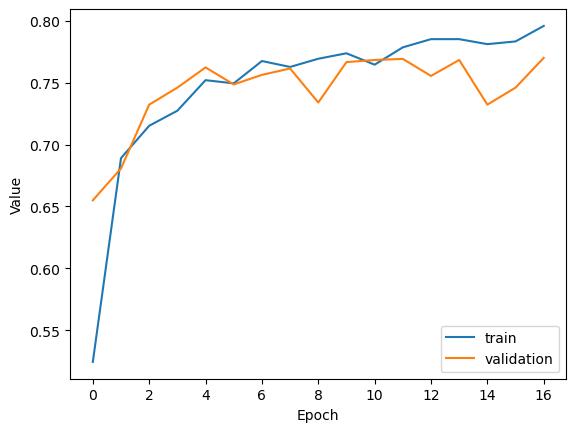

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


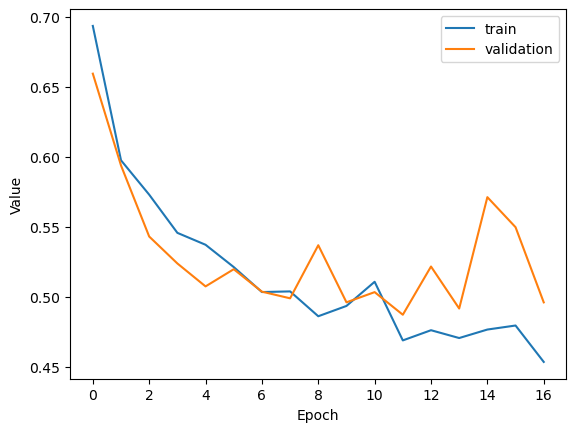

In [319]:
# # Plotting accuracy 
print(history.history.keys())
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.show() 

# # Plotting loss
print(history.history.keys())
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Precision: 0.7846846664566274
Recall: 0.784631190178943
F1 Score: 0.7846567919075146

Confusion Matrix:
 [[686 178]
 [180 621]]


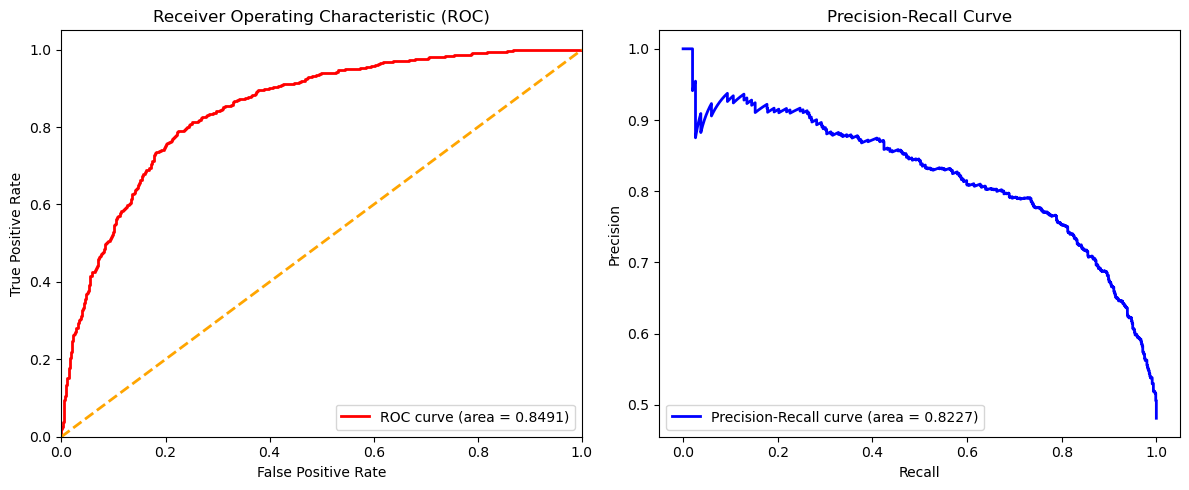

In [92]:

# probabilities
y_pred_prob = CNN_best.predict(X_test)


# Performance metrics
print("Precision:", precision_score(y_test, cnn_y_pred_best, average='macro'))
print("Recall:", recall_score(y_test, cnn_y_pred_best, average='macro'))
print("F1 Score:", f1_score(y_test, cnn_y_pred_best, average='macro'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, cnn_y_pred_best))

def plot_roc_and_pr_curves(y_test, y_pred_prob, class_label=1):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, class_label])
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, class_label])
    pr_auc = auc(recall, precision)

    # Plot ROC curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.4f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# ROC curve and precision-recall curve for CNN model
plot_roc_and_pr_curves(y_test, y_pred_prob)


In [323]:
#Flattening 
numberoftrain = X_train.shape[0]
numberoftest = X_test.shape[0]
numberofval=X_val.shape[0]
X_train = X_train.reshape(numberoftrain,X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_test = X_test.reshape(numberoftest,X_test.shape[1]*X_test.shape[2]*X_test.shape[3])
X_val = X_val.reshape(numberofval,X_val.shape[1]*X_val.shape[2]*X_val.shape[3])
print("X Train: ",X_train.shape)
print("X Test: ",X_test.shape)
print("X Val: ",X_val.shape)

X Train:  (2717, 7500)
X Test:  (1665, 7500)
X Val:  (1165, 7500)


### Decision Tree 

In [133]:
Decision_tree = DecisionTreeClassifier()
Decision_tree.fit(X_train, y_train)
y_pred = Decision_tree.predict(X_test)

#Performance metrics
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("\nDecision_tree_cm:\n",confusion_matrix(y_test, y_pred))

Accuracy :  0.6696696696696697
Precision: 0.6696810935912827
Recall: 0.6699243133583022
F1 Score: 0.6695551199741345

Decision_tree_cm:
 [[573 291]
 [259 542]]


In [326]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# DecisionTreeClassifier
Decision_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=Decision_tree, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-validation Score:", best_score)

c:\Users\shakuntal shinde\anaconda3\anaconda\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\shakuntal shinde\anaconda3\anaconda\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\shakuntal shinde\anaconda3\anaconda\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\shakuntal shinde\anaconda3\anaconda\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Best Cross-validation Score: 0.7048261293467663


In [327]:
# new model with the best parameters
Decision_tree_new = DecisionTreeClassifier(**best_params)
Decision_tree_new.fit(X_train, y_train)
test_score = Decision_tree_new.score(X_test, y_test)
DT_y_pred=Decision_tree_new.predict(X_test)


#Performance metrics
print("Accuracy : ", accuracy_score(y_test, DT_y_pred))
print("Precision:", precision_score(y_test, DT_y_pred, average='macro'))
print("Recall:", recall_score(y_test, DT_y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, DT_y_pred, average='macro'))
print("\nDecision_tree_new_cm:\n",confusion_matrix(y_test, DT_y_pred))



Accuracy :  0.7063063063063063
Precision: 0.706265108959049
Recall: 0.7049066271327507
F1 Score: 0.7051111033039248

Decision_tree_new_cm:
 [[641 223]
 [266 535]]


In [321]:
import pickle

# Save the model
with open('Decision_tree_new.pkl', 'wb') as f:
    pickle.dump(Decision_tree_new,f)

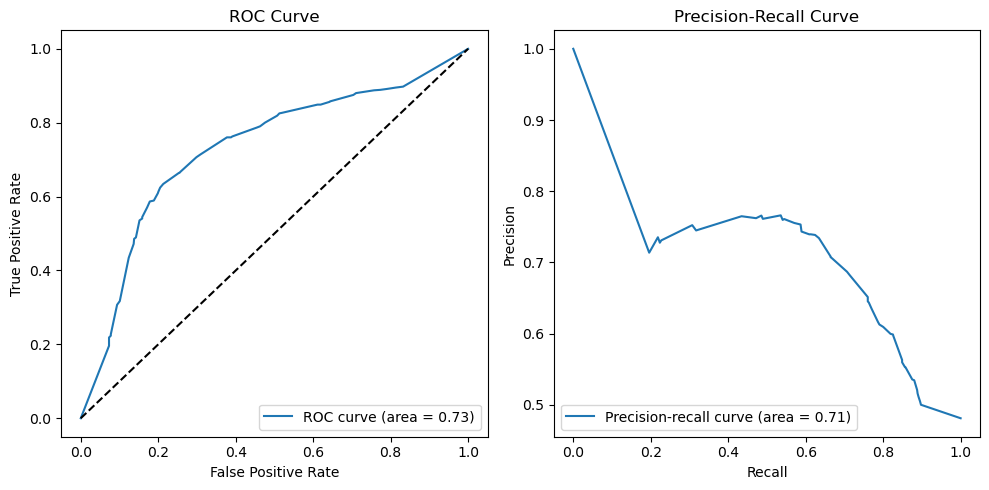

In [340]:
def plot_roc_and_pr_curves(y_test, DT_y_prob):
    fpr, tpr, _ = roc_curve(y_test, DT_y_prob)
    precision, recall, _ = precision_recall_curve(y_test, DT_y_prob)
    
    # ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    
    # precision-recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='Precision-recall curve (area = {:.2f})'.format(auc(recall, precision)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

DT_y_prob = Decision_tree_new.predict_proba(X_test)[:, 1]
plot_roc_and_pr_curves(y_test, DT_y_prob)



### Support Vector Machine

In [140]:
SVM = SVC(random_state=42)
SVM.fit(X_train,y_train)   
SVM_y_pred = SVM.predict(X_test)


svmsc = SVM.score(X_test,y_test)
print ("SVM Accuracy:", SVM.score(X_test,y_test))
print("Precision:", precision_score(y_test, SVM_y_pred, average='macro'))
print("Recall:", recall_score(y_test, SVM_y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, SVM_y_pred, average='macro'))
print("\nSVM_cm:\n",confusion_matrix(y_test, SVM_y_pred))

SVM Accuracy: 0.7645645645645646
Precision: 0.7642311260900606
Recall: 0.7641814918851435
F1 Score: 0.7642052023121386

SVM_cm:
 [[669 195]
 [197 604]]


In [141]:
# parameter grid for SVM
param_grid = {
    'C': [0.1, 1,10],  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'gamma': ['scale', 'auto'],  
    
}

SVM = SVC(random_state=42)
grid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
SVM_new = SVC(probability=True)
grid_search.fit(X_train, y_train)

best_params_SVM = grid_search.best_params_
best_score_SVM = grid_search.best_score_

print("Best parameters for SVM:", best_params_SVM)
print("Best cross-validated score:", best_score_SVM)



Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validated score: 0.7703329812588018


In [143]:
# new model with the best parameters 
SVM_new = grid_search.best_estimator_
svmsc = SVM_new.score(X_test, y_test)
SVM_new_y_pred = SVM_new.predict(X_test)

print("Accuracy for SVM with best parameters:", svmsc)
print("Precision:", precision_score(y_test, SVM_new_y_pred, average='macro'))
print("Recall:", recall_score(y_test, SVM_new_y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, SVM_new_y_pred, average='macro'))
print("\nSVM_new_cm:\n",confusion_matrix(y_test, SVM_new_y_pred))

Accuracy for SVM with best parameters: 0.766966966966967
Precision: 0.7667852581645686
Recall: 0.7662232105701208
F1 Score: 0.7664141414141414

SVM_new_cm:
 [[679 185]
 [203 598]]


In [144]:
SVM_new = SVC(probability=True, random_state=42)
SVM_new.fit(X_train, y_train)

SVC(probability=True, random_state=42)

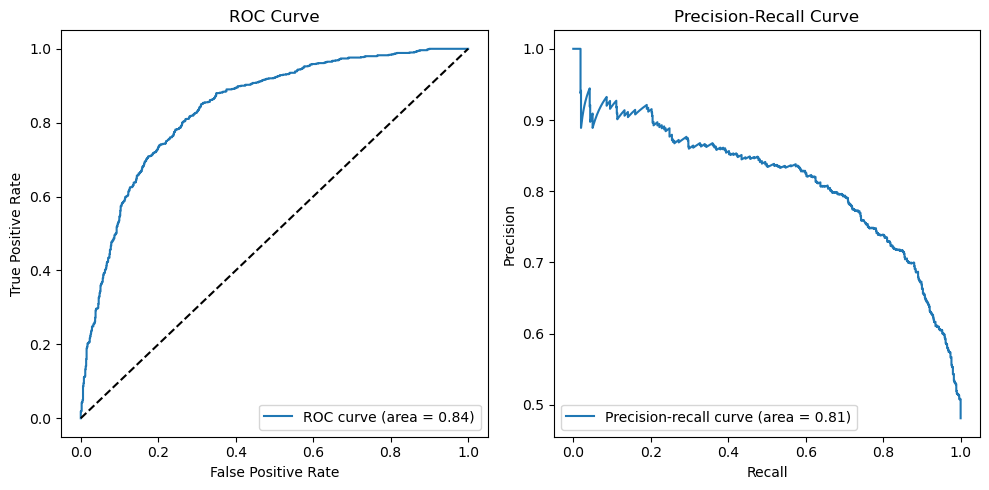

In [145]:
SVM_y_prob = SVM_new.predict_proba(X_test)[:, 1]
def plot_roc_and_pr_curves(y_test, SVM_y_prob):
    fpr, tpr, _ = roc_curve(y_test, SVM_y_prob)
    precision, recall, _ = precision_recall_curve(y_test, SVM_y_prob)
    
    # ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    
    # precision-recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='Precision-recall curve (area = {:.2f})'.format(auc(recall, precision)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

#SVM_y_prob = SVM_new.predict_proba(X_test)[:, 1]  

plot_roc_and_pr_curves(y_test, SVM_y_prob)

### Random Forest 

In [146]:

RFC= RandomForestClassifier(n_estimators = 100, random_state=42) 
RFC.fit(X_train,y_train) 
print("Random Forest Score: ",RFC.score(X_test,y_test))
RFC_y_pred = RFC.predict(X_test)
print("Precision:", precision_score(y_test, RFC_y_pred, average='macro'))
print("Recall:", recall_score(y_test, RFC_y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, RFC_y_pred, average='macro'))
print("Random_forest_cm:\n",confusion_matrix(y_test, RFC_y_pred))



Random Forest Score:  0.7525525525525526
Precision: 0.7522478041681826
Recall: 0.7524708697461506
F1 Score: 0.752320170535784
Random_forest_cm:
 [[652 212]
 [200 601]]


In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

RFC = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validated score: ", best_score)

c:\Users\shakuntal shinde\anaconda3\anaconda\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters found:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validated score:  0.7769662008449789


In [150]:
# Training
Random_forest_new = grid_search.best_estimator_
Random_forest_new.fit(X_train, y_train)
# Evaluation
RFC_new_y_pred = Random_forest_new.predict(X_test)

print("Accuracy: ", Random_forest_new.score(X_test, y_test))
print("Precision:", precision_score(y_test, RFC_new_y_pred, average='macro'))
print("Recall:", recall_score(y_test, RFC_new_y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, RFC_new_y_pred, average='macro'))
print("RFC_new_cm:\n",confusion_matrix(y_test, RFC_new_y_pred))


c:\Users\shakuntal shinde\anaconda3\anaconda\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy:  0.7585585585585586
Precision: 0.758525309716126
Recall: 0.7588951310861423
F1 Score: 0.7584636769902307
RFC_new_cm:
 [[648 216]
 [186 615]]


In [151]:
import pickle

# Save the model
with open('Random_forest_new', 'wb') as f:
    pickle.dump(Random_forest_new,f)

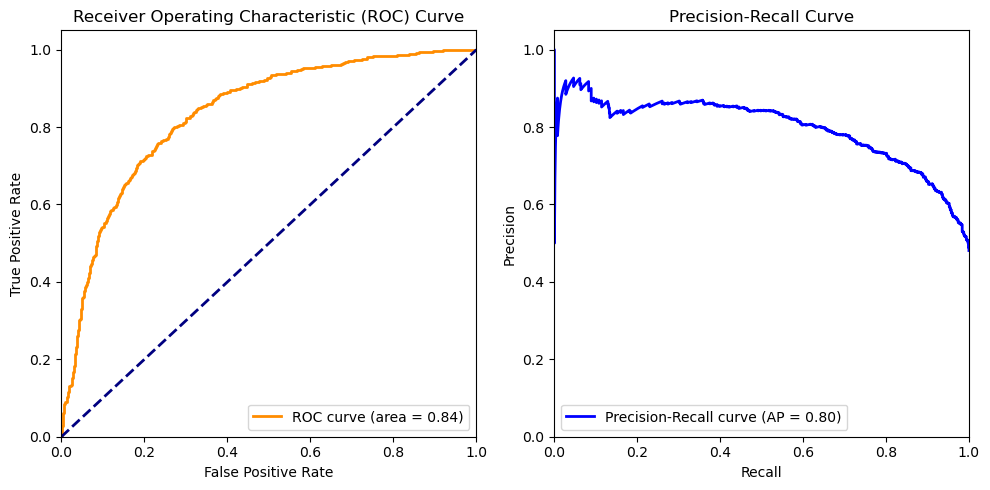

In [152]:
RFC_y_prob = Random_forest_new.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, RFC_y_prob)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, RFC_y_prob)
average_precision = average_precision_score(y_test, RFC_y_prob)

# ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# precision-recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()



### Evaluation and Visualization :
For evaluating the model performance, several factors were taken into consideration.
Looking at the confusion matrix, as in medical field accuracy holds major importance, model that predicts cancer more correctly with low false negative value was considered for evaluation of the best model.
Considering accuracies of the model, decision tree is not recommendable as its accuracy is lower than the other models. Decision trees struggle with complex structure of the data especially when the images are involved which makes it less suitable for image classification tasks. The precision recall curve for decision tree is not set good enough leading model to underfitting and displaying threshold sensitivity to the set value. For random forest classifier, the confusion matrix shows the false negative value low as compared to other machine learning models making it recommendable for using it for classifying the cancer images, but the precision, recall and F1 values are slightly lower than SVM. As SVM is versatile model for its ability to handle high dimensional data, SVM has highest accuracy among the machine learning model with high precision recall values which makes it suitable for the use in diagnosing the cancer. With the CNN model, the model is accurate enough with good threshold value in precision recall graph. Other performance metrics gave the high values which indicates CNN has performed well showing good positive true values while avoiding false positive values.
From the evaluation it can be said that CNN model is recommended while classifying the images into cancerous and non-cancerous where SVM showcases some good performance metrics indicating it has high effectiveness in classifying the images among all other machine learning models.


In [328]:
# performance metrics
performance_metrics = {
    "Model": ["CNN", "Decision Tree", "SVM", "Random Forest"],
    "Accuracy": [0.7846, 0.7063, 0.7669, 0.7586],
    "Precision": [0.7802, 0.6763, 0.7642, 0.7585],
    "Recall": [0.7802, 0.6766, 0.7642, 0.7589],
    "F1 Score": [0.7790, 0.6762, 0.7642, 0.7585]
}

performance_metrics["Accuracy"] = [val * 100 for val in performance_metrics["Accuracy"]]

df = pd.DataFrame(performance_metrics)
df.set_index('Model', inplace=True)

model_colors = {
    "CNN": "background-color: blue",
    "Decision Tree": "background-color: green",
    "SVM": "background-color: lightcoral",
    "Random Forest": "background-color: red"
}

def color_rows(row):
    return [model_colors[row.name]] * len(row)
df_styled = df.style.apply(color_rows, axis=1)
df_styled



,Accuracy,Precision,Recall,F1 Score
Model,,,,
CNN,78.460000,0.780200,0.780200,0.779000
Decision Tree,70.630000,0.676300,0.676600,0.676200
SVM,76.690000,0.764200,0.764200,0.764200
Random Forest,75.860000,0.758500,0.758900,0.758500


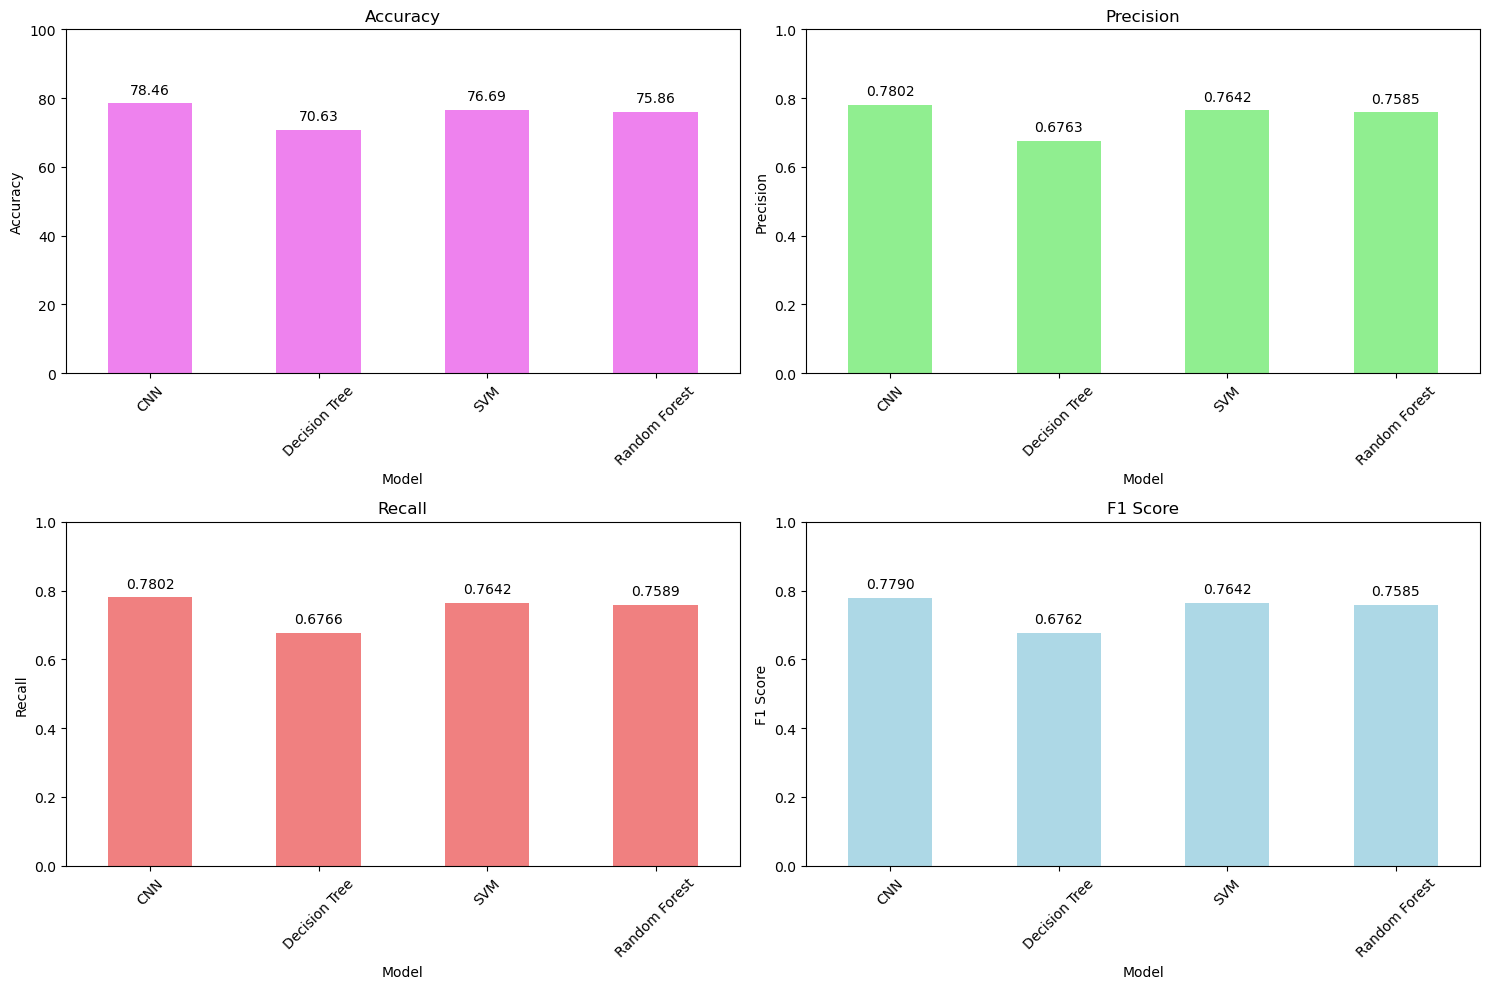

In [329]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
colors = ["violet", "lightgreen", "lightcoral", "lightblue"]

for ax, metric, color in zip(axes.flatten(), metrics, colors):
    df[metric].plot(kind='bar', ax=ax, color=color)
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1 if metric != "Accuracy" else 100)  #
    ax.set_xticklabels(df.index, rotation=45)
    
    
    for p in ax.patches:
        value = p.get_height()
        label = f"{value:.4f}" if metric != "Accuracy" else f"{value:.2f}"
        ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

### Conclusion: 
In the medical field while diagnosing any disease, it is very important to consider recall value along with accuracy as recall represents false negative values as it is always better to have larger false positive value than the false negative. Considering this point, SVM performs best among all the model followed by CNN with almost same accuracy but the difference with other performance metrics. Overall, the choice of model may depend on the specific requirements of the application. Considering the scenario where minimizing false positives is crucial, CNN the would be the preferred choice. For a balanced performance across all metrics, SVM the stands out. These models can be further refined and combined with other techniques, such as ensemble methods, to enhance their performance in clinical settings, potentially leading to more accurate and early detection of breast cancer.


### Reference:
Liu, H., Mihaela Cocea and Ding, W. (2017). Decision tree learning based feature evaluation and selection for image classification. Portsmouth Research Portal (University of Portsmouth). [online] doi: https://doi.org/10.1109/icmlc.2017.8108975.

Mayank Arya Chandra and Bedi, S.S. (2018). Survey on SVM and their application in image classification. International journal of information technology, [online] 13(5), pp.1–11. doi: https://doi.org/10.1007/s41870-017-0080-1.

Safdar, J., Elazab, A., Lei, B. and Wang, T. (2019). Breast Cancer Detection and Diagnosis Using Mammographic Data: Systematic Review. JMIR. Journal of medical internet research/Journal of medical internet research, [online] 21(7), pp.e14464–e14464. doi: https://doi.org/10.2196/14464.

Sun, Y.-S., Zhao, Z., Yang, Z.-N., Xu, F., Lu, H.-J., Zhu, Z.-Y., Shi, W., Jiang, J., Yao, P.-P. and Zhu, H.-P. (2017). Risk Factors and Preventions of Breast Cancer. International journal of biological sciences, [online] 13(11), pp.1387–1397. doi: https://doi.org/10.7150/ijbs.21635.

Taye Girma Debelee, Schwenker, F., Achim Ibenthal and Yohannes, D. (2019). Survey of deep learning in breast cancer image analysis. Evolving systems, [online] 11(1), pp.143–163. doi: https://doi.org/10.1007/s12530-019-09297-2.

Xu, B., Ye, Y. and Nie, L. (2012). An improved random forest classifier for image classification. [online] doi: https://doi.org/10.1109/icinfa.2012.6246927.
